In [1]:
#need to install to import and call LGBMClassifier
!pip install lightgbm

In [396]:
#need to install to import and call XGBClassifier
!pip install xgboost

In [209]:
import pandas as pd
import numpy as np
import re #regular expressions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #scales data
from sklearn.preprocessing import LabelEncoder  #converts strings to integers by encoding
from sklearn.feature_selection import SelectFromModel  #reduces features to be train on based on importance to reduce noise,
from sklearn.feature_selection import RFECV #selects the most important features for your model
# model scores:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# hyperameters 
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# samplers
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
#models: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier




In [3]:
#read in the CSV
df = pd.read_csv('incident_event_log.csv')

In [4]:
#at first glance it looks like there are no missing values however we know they use ? inplace of NaN values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           141712 non-null  object
 11  sys_created_at           141712 non-null  object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

In [5]:
#change all ? marks to NAN values so we can manipulate them easier
df_nan = df.copy()
df_nan = df.replace('?',np.nan)

In [6]:
#Now we can see the columns with missing values
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141683 non-null  object
 8   opened_by                136877 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           88636 non-null   object
 11  sys_created_at           88636 non-null   object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

In [7]:
#changing all objects to datetime values in the date columns
df_nan['opened_at']= pd.to_datetime(df_nan['opened_at'],dayfirst= True)
df_nan['resolved_at'] = pd.to_datetime(df_nan['resolved_at'], dayfirst = True)
df_nan['closed_at'] = pd.to_datetime(df_nan['closed_at'],dayfirst = True)
df_nan['sys_created_at'] = pd.to_datetime(df_nan['sys_created_at'],dayfirst = True)


In [8]:
# creating a difference column to show the amount of days it takes to resolve a ticket that will be used for the target column
df_nan['difference'] = (df_nan['resolved_at'] - df_nan['opened_at']).dt.days
#checking to see the time in days it takes from resolving a ticket and closing a ticket
df_nan['resolved_closed_diff'] = (df_nan['closed_at'] - df_nan['resolved_at']).dt.days

In [9]:
#looking at the distrabution of days it takes to close a ticket after its been resolved
df_nan.value_counts('resolved_closed_diff')

resolved_closed_diff
5.0     117907
7.0       2999
6.0       2144
10.0      1904
15.0      1842
         ...  
49.0         2
56.0         2
57.0         2
63.0         2
38.0         2
Name: count, Length: 68, dtype: int64

Below are mutiple versions for a target column using the difference between the columns opened_at and resolved at. The target column gives us a binary output depending on the difference between these columns and then deciding the cut off point for our zero and ones. We have decided to use 2 days as our cut off point, but have not yet tested the other target columns for our Y value in the models.

In [10]:
#creates a target column of 0s and 1s based on the amount of days it took to resolve the incident.
#if the amount of days is greater than 2 or NAN it turns to 1 and if 2 or below it is a 0
df_nan['target_colum'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 2 else 0, axis = 1)

#One day target column
df_nan['one_day_solve'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 1 else 0, axis = 1)

#three day target column
df_nan['three_day_solve'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 3 else 0, axis = 1)

#four day target column
df_nan['four_day_solve'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 4 else 0, axis = 1)

#five day target column
df_nan['five_day_solve'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 5 else 0, axis = 1)

#6 day target column
df_nan['six_day_solve'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 6 else 0, axis = 1)

In [11]:
df_nan.value_counts('one_day_solve')

one_day_solve
1    81257
0    60455
Name: count, dtype: int64

In [12]:

#creating another option for target column using the time the ticket was closed instead of solved
df_nan['target_closed'] = df_nan.apply(lambda row: 1 if (row['closed_at'] - row['opened_at']).days > 2 else 0, axis = 1)
# looks way to unbalanced, not a good idea
df_nan.value_counts('target_closed')

target_closed
1    141312
0       400
Name: count, dtype: int64

In [13]:
#shows a balanced target column for the 2 day target values
df_nan.value_counts('target_colum')

target_colum
1    73232
0    68480
Name: count, dtype: int64

In [14]:
# Creating a function to prioritize 'new' and 'active' incident states that will emliminate duplicate incident numbers
"""Parmerter: takes grouped data frame and applys to each group of data
returns a data frame that only includes one instance of every value in the 'number' column
that has a correlating 'incident_state' value of 'New' if possible and then filters to 'active', 
while also including one instance of a 'number' that does not have new or active in 'incident_state'
Returns filtered data frame"""
def new_active_incident_state(group):
    if (group['incident_state'] == 'New').any():
        return group[group['incident_state'] == 'New'].iloc[0]
    elif (group['incident_state'] == 'Active').any():
        return group[group['incident_state'] == 'Active'].iloc[0]
    else:
        return group.iloc[0]  # In case neither 'new' nor 'active' exists, retain the first occurrence

# Apply this function to the DataFrame by grouping by 'number'
df_new_active = df_nan.groupby('number',group_keys=False).apply(new_active_incident_state).reset_index(drop=True)
# View the result
#df_new_active

###warning note: group_keys = Flase is not yet apart of pandas and thus will not work, however by including group_keys = False exlcudes the 'number' column form being included in the apply results and should avoid altering the sturcture of the result


C:\Users\tyzwh\AppData\Local\Temp\ipykernel_24340\712818713.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_new_active = df_nan.groupby('number',group_keys=False).apply(new_active_incident_state).reset_index(drop=True)


In [15]:
display(df_new_active.value_counts('one_day_solve')) #1 day target balance
display(df_new_active.value_counts('target_colum')) #2 day resolve target
display(df_new_active.value_counts('three_day_solve')) #3 day target balance
display(df_new_active.value_counts('four_day_solve')) #4 day target balance
display(df_new_active.value_counts('five_day_solve')) #5 day target balance
display(df_new_active.value_counts('six_day_solve')) #6 day target balance

one_day_solve
0    13905
1    11013
Name: count, dtype: int64

target_colum
0    15095
1     9823
Name: count, dtype: int64

three_day_solve
0    15951
1     8967
Name: count, dtype: int64

four_day_solve
0    16619
1     8299
Name: count, dtype: int64

five_day_solve
0    17282
1     7636
Name: count, dtype: int64

six_day_solve
0    18001
1     6917
Name: count, dtype: int64

In [16]:
#This shows us that made_sla changes value after the ticket is initially created
df_new_active.value_counts('made_sla')

made_sla
True     24917
False        1
Name: count, dtype: int64

In [17]:

# Creating a function to prioritize 'made_sla' and capture all the unique False values from the number column first and then filling with left over unique True values
def made_sla_false(group):
    """using the same concept from the function new_active_state but instead uses Made_sla to filter
    Parmerter: takes grouped data frame and applys to each group of data
returns a data frame that only includes one instance of every value in the 'number' column
that has a correlating 'made_sla' value of 'False' if possible and then filters to 'True', 
Returns: filtered data frame
    """
    if (group['made_sla'] == False).any():
        return group[group['made_sla'] == False].iloc[0]
    else:
        return group.iloc[0]
    
#apply function to daframe with groupby
df_made_sla_false = df_nan.groupby('number', group_keys=False).apply(made_sla_false).reset_index(drop = True)

#looking at the relationship bewteen made_sla and the target_column
display(df_made_sla_false.value_counts('target_colum'))
display(df_made_sla_false.value_counts('made_sla'))

C:\Users\tyzwh\AppData\Local\Temp\ipykernel_24340\676905345.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_made_sla_false = df_nan.groupby('number', group_keys=False).apply(made_sla_false).reset_index(drop = True)


target_colum
0    15095
1     9823
Name: count, dtype: int64

made_sla
True     15803
False     9115
Name: count, dtype: int64

In [18]:
#allows me to check if the values are same column by column
# This has shown me that opened_at has the same values, but resolved at does not needs further investigation 
if (df_new_active['resolved_at'] == df_made_sla_false['resolved_at']).all():
    print('Match!')
else:
    print('Nope')

Nope


NaN values: If any of the values are NaN in either of the DataFrames, the comparison will return False because NaN == NaN is False.
This is causing the above code to print Nope even though the values actually do match for my purposes

In [19]:
#group by 'number' and filter for groups where the 'difference' values are not the same
different_values_df = df_nan.groupby('number').filter(lambda x: x['difference'].nunique() > 1)

#display the new DataFrame with numbers that have different 'difference' values
different_values_df


,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,closed_at,difference,resolved_closed_diff,target_colum,one_day_solve,three_day_solve,four_day_solve,five_day_solve,six_day_solve,target_closed


The above cell produces an empty dataframe proving that resolved_at does not have different values depending on which unique row based on the 'number' column

In [20]:
#allows me to check if the values are same column by column between 2 different dataframes filtered to unique tickets
#this shows me that even though the resolved_at doesnt match, the target column does, thus we will move forward with our filtered df_new_active dataframe
if (df_new_active['target_colum'] == df_made_sla_false['target_colum']).all():
    print('Match!')
else:
    print('Nope')

Match!


In [21]:
#looking at the distrabution of days it takes to close a ticket after its been resolved
#going to investigate the possible outlier for the difference of 243
df_new_active.value_counts('resolved_closed_diff')

resolved_closed_diff
5.0      20134
7.0        419
6.0        322
10.0       303
15.0       281
         ...  
44.0         1
48.0         1
57.0         1
56.0         1
243.0        1
Name: count, Length: 68, dtype: int64

In [22]:
#shows all the columns without condensing the dataframe with ...
pd.set_option('display.max_columns', None)
#looking at a specific incident ticket that has the largest difference between resolved_at and closed_at 
df_new_active.loc[df_new_active['resolved_closed_diff'] == 243]

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,resolved_closed_diff,target_colum,one_day_solve,three_day_solve,four_day_solve,five_day_solve,six_day_solve,target_closed
13953,INC0020336,New,True,0,0,0,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 370,18/4/2016 11:07,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 194,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,243.0,0,0,0,0,0,0,1


In [23]:
#looking at the orginal dataframe to see all the instances for the same ticket number with the long delay in close time after being resolved
df_nan.loc[df_nan['resolved_closed_diff'] == 243]

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,resolved_closed_diff,target_colum,one_day_solve,three_day_solve,four_day_solve,five_day_solve,six_day_solve,target_closed
84918,INC0020336,New,True,0,0,0,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 370,18/4/2016 11:07,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 194,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,243.0,0,0,0,0,0,0,1
84919,INC0020336,New,True,0,0,1,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 370,18/4/2016 11:08,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 194,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,243.0,0,0,0,0,0,0,1
84920,INC0020336,New,True,1,0,3,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 60,18/4/2016 15:56,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 39,Resolver 194,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,243.0,0,0,0,0,0,0,1
84921,INC0020336,Resolved,True,1,0,4,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 748,18/4/2016 16:03,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 39,Resolver 194,False,True,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,243.0,0,0,0,0,0,0,1
84922,INC0020336,Closed,False,1,0,5,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 908,23/4/2016 16:07,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 39,Resolver 194,False,True,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,243.0,0,0,0,0,0,0,1
84923,INC0020336,Closed,False,1,0,6,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 40,18/12/2016 11:42,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 39,Resolver 194,False,True,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,243.0,0,0,0,0,0,0,1


In [24]:
#looking at the values in priority which is calculated by the system based on 'impact' and 'urgency';
display(df_new_active['priority'])
display(df_new_active.value_counts('priority'))

0        3 - Moderate
1        3 - Moderate
2        3 - Moderate
3        3 - Moderate
4        3 - Moderate
             ...     
24913    3 - Moderate
24914         4 - Low
24915    3 - Moderate
24916    3 - Moderate
24917    3 - Moderate
Name: priority, Length: 24918, dtype: object

priority
3 - Moderate    23681
4 - Low           741
2 - High          311
1 - Critical      185
Name: count, dtype: int64

In [239]:
#group by 'number' and filter for groups where the 'priority' values are not the same
different_priority_df = df_nan.groupby('number').filter(lambda x: x['priority'].nunique() > 1)

#display the new DataFrame with numbers that have different 'priority' values
display(different_priority_df[['number', 'priority']].head(25))
display(different_priority_df[['number', 'priority']].tail(25))



,number,priority
24,INC0000062,3 - Moderate
25,INC0000062,2 - High
26,INC0000062,2 - High
27,INC0000062,2 - High
28,INC0000062,2 - High
29,INC0000062,2 - High
30,INC0000062,2 - High
31,INC0000062,2 - High
224,INC0000104,3 - Moderate
225,INC0000104,2 - High


,number,priority
141457,INC0114499,3 - Moderate
141458,INC0114499,3 - Moderate
141459,INC0114499,3 - Moderate
141460,INC0114499,3 - Moderate
141461,INC0114499,3 - Moderate
141462,INC0114499,2 - High
141463,INC0114499,1 - Critical
141464,INC0114499,1 - Critical
141465,INC0114499,1 - Critical
141466,INC0114499,1 - Critical


The cells above have shown me that priority does change over the duration of the tickets entries, however it seems that they all at least start with moderate, which shows that my df_new_active has mostly captured the initial tikcket with the moderate rating. however I need to investigate the tickets that I have captured that don't have a moderate rating? Are they not the first instance of the ticekt,


My current model does not use the rating columns in its featrue selection, and these findings validates that choice.

In [26]:
print(df_new_active['priority'].unique())

['3 - Moderate' '4 - Low' '1 - Critical' '2 - High']


In [27]:
#creating dataframe that captures all the critical and priority tickets to see their target column results from the filtered df
df_critical_high = df_new_active[(df_new_active['priority'] == '1 - Critical') | (df_new_active['priority'] == '2 - High')]
df_critical_high.value_counts('target_colum')

target_colum
0    274
1    222
Name: count, dtype: int64

In [28]:
df_critical_high[['number']].head(5)

,number
111,INC0000261
173,INC0000370
200,INC0000433
224,INC0000508
231,INC0000517


In [29]:
#lets look at the orginal dataframe with one of the 'number' values below to make sure we are capturing the first priority value for a given number
df_nan.loc[df_nan['number'] == 'INC0000433']

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,resolved_closed_diff,target_colum,one_day_solve,three_day_solve,four_day_solve,five_day_solve,six_day_solve,target_closed
1285,INC0000433,New,True,0,0,0,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 578,29/2/2016 20:58,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,5.0,1,1,1,1,1,1,1
1286,INC0000433,New,True,0,0,1,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 111,29/2/2016 21:40,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,5.0,1,1,1,1,1,1,1
1287,INC0000433,New,True,0,0,2,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 578,29/2/2016 22:16,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,5.0,1,1,1,1,1,1,1
1288,INC0000433,New,True,0,0,5,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 432,8/3/2016 16:43,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,5.0,1,1,1,1,1,1,1
1289,INC0000433,New,True,0,0,6,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 432,8/3/2016 17:18,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,5.0,1,1,1,1,1,1,1
1290,INC0000433,Active,True,0,0,7,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 432,8/3/2016 17:39,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,5.0,1,1,1,1,1,1,1
1291,INC0000433,Resolved,True,0,0,8,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 578,25/3/2016 23:57,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,True,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,5.0,1,1,1,1,1,1,1
1292,INC0000433,Closed,False,0,0,9,False,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 908,30/3/2016 23:59,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,True,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,5.0,1,1,1,1,1,1,1


The tickets with critical and high values in the priority column do seem to be initial imputs from when the ticket was made, thus we will keep these in the training set. however as you can see even with higher values, these tickets still have a balanced target column thus won't help the model predict.

In [30]:
#This shows that our filtered dataFrame retains all of the unique values in the 'number' column
duplicates_list = df_nan['number'].unique().tolist()
display(len(duplicates_list))
unique_list_check = df_new_active['number'].unique().tolist()
display(len(unique_list_check))

24918

24918

In [31]:
#this shows that we have a slightly imbalanced data set with 2x as many trues than falses, will probably have to use sampler
df_new_active['target_colum'].value_counts()

target_colum
0    15095
1     9823
Name: count, dtype: int64

In [32]:
#shows the total 8 possible values for filtering compared to the output of our filtered data frame
display(df_nan.value_counts('incident_state'))
display(df_new_active.value_counts('incident_state'))


incident_state
Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
-100                      5
Name: count, dtype: int64

incident_state
New                   16397
Active                 6566
Resolved               1816
Awaiting User Info      133
Awaiting Problem          6
Name: count, dtype: int64

**Who are we presenting too:** ServiceNow Research and Development ITSM department

#### Target **complete
* create target column: numbers of days ticket is open???
* what could this tell us, or how could we explain this as usefull: if we can succesfully predict whether an incident will be resolved in sufficent time given info porovided about the incident. Then we could advise...???
* who wants this?

#### TO DO List
* **complete** figure out how to filter to find all duplicate incedents for same value in 'number' and only retain 1 incedence set to 'incident_status == 'new'
* **complete**create repository and seperate branches  link: https://github.com/Sug-ar-N-Spice/Incident_Events.git
* **complete**turn all ? into NANs
* **complete**find documentation/info of columns   link: https://archive.ics.uci.edu/dataset/498/incident+management+process+enriched+event+log
* **semi-complete**create target column: complete for tickets open over 2 days
* **complete** decide if there are any columns we can get drop ..ex.'number'
* **complete** decide what columns would cuase dataleaks to give the model all the answers renderring our model useless..ex. time/date, days open, other columns?
* **complete**Parameter loops

* DO we need a standard scaler( don't need it)
* Do we need resampler(need it)

* **complete** list all columns with NaN values
* **complete** find the NANS and figure out how to fill
* ** complete** replace strings with numbers
* **complete** list out the models that we will attempt to use find code examples/syntax ready
* **complete** Find other versions of random forest classifire 

**Curenlty working on:**
* Param_grids for different models
* feature selection
* storing model results
  
**Future Objectives**
* test models with alternative target colums
* reassess data cleaning methods
  

In [33]:
df_nan.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
       'difference', 'resolved_closed_diff', 'target_colum', 'one_day_solve',
       'three_day_solve', 'four_day_solve', 'five_day_solve', 'six_day_solve',
       'target_closed'],
      dtype='object')

## create a data frame with the following columns for training
#List of columns to keep for Training set:
* opened_by: identifier of the user who reported the incident
* opened_at: incident user opening date and time
* contact_type: categorical attribute that shows by what means the incident was reported
* location: identifier of the location of the place affected
* category: first-level description of the affected service
* subcategory: second-level description of the affected service (related to the first level description, i.e., to category);
* u_symptom: description of the user perception about service availability
* impact: description of the impact caused by the incident (values: 1â€“High; 2â€“Medium; 3â€“Low);
* urgency: description of the urgency informed by the user for the incident resolution (values: 1â€“High; 2â€“Medium; 3â€“Low);
* priority: calculated by the system based on 'impact' and 'urgency';
* assignment_group: identifier of the support group in charge of the incident;
* assigned_to: identifier of the user in charge of the incident;
* knowledge: boolean attribute that shows whether a knowledge base document was used to resolve the incident;
* u_priority_confirmation: boolean attribute that shows whether the priority field has been double-checked;
* notify: categorical attribute that shows whether notifications were generated for the incident;

### Too many missing values? (re-evalue to possibly fill and add back in)
* rfc: (98 entries)(request for change) identifier of the change request associated with the incident;
* cmdb_ci: (only has 51 entries) (confirmation item) identifier used to report the affected item (not mandatory)
* vendor:(probably drop only 15 entries) identifier of the vendor in charge of the incident;
* caused_by:(drop only 2 entires) identifier of the RFC responsible by the incident
* problem_id:(241 entries) identifier of the problem associated with the incident;
*  sys_created_by: identifier of the user who registered the incident
* sys_created_at: incident system creation date and time


list of potential:exclude these columns
* sys_updated_by:(? is this generated day 1?) identifier of the user who updated the incident and generated the current log record
* sys_updated_at:(?day 1 info?) incident system update date and time


## list of columns not used in training set
number, incident_state, active, reassignment_count, reopen_count, sys_mod_count, made_sla, caller_id,
sys_created_by, sys_created_at, sys_updated_by, sys_updated_at, closed_code, resolved_by, resolved_at, closed_at

|header  |  |
|--|--|
| values |  |

In [34]:
df_caused_by = df_new_active[df_new_active['caused_by'].notna()]
df_caused_by

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,resolved_closed_diff,target_colum,one_day_solve,three_day_solve,four_day_solve,five_day_solve,six_day_solve,target_closed
186,INC0000388,New,True,0,0,0,True,Caller 2020,Opened by 221,2016-02-29 16:43:00,Created by 98,2016-02-29 16:49:00,Updated by 429,29/2/2016 16:49,Phone,Location 204,Category 45,Subcategory 94,Symptom 208,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 33,Resolver 216,True,False,Do Not Notify,Problem ID 17,CHG0000132,NaN,CHG0000132,code 7,Resolved by 197,2016-03-22 16:47:00,2016-03-27 16:59:00,22.0,5.0,1,1,1,1,1,1,1
663,INC0001131,New,True,0,0,0,True,Caller 93,Opened by 40,2016-03-02 10:41:00,Created by 20,2016-03-02 10:43:00,Updated by 88,2/3/2016 10:43,Phone,Location 161,Category 45,Subcategory 223,Symptom 437,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 216,True,False,Do Not Notify,Problem ID 8,CHG0000097,NaN,CHG0000097,code 6,Resolved by 197,2016-03-22 16:38:00,2016-03-27 16:59:00,20.0,5.0,1,1,1,1,1,1,1


### Filling missing NANs:
*sys_created_at and sys_created_by have the same missing values(took out of training data frame) check passes and fails count, dont know if this is day one info because the time is past the opened_at time???
### Converting strings into numbers: list to convert
**complete**
### converted dates
* opened_at (seperate into 2 or 3 columns) No Nan values: seperated into 3 columns, day of week, month, year
### filled with grab_number_last
* opened_by (714 NaNs)
* location (51 NaNs)
* category (39 NaNs)
* subcategory
* u_symptom
* assignment_group
* assigned_to
* problem_id (241 entries) exfill_df
* cmdb_ci (51 entries) exfill_df
* caller Id (not in inital model tests)
### columns filled with grab_1rst_num
* urgency
* priority
* impact
### Filled w/ onehot_bool
*knowledge
u_priority_confirmation
### Filled with get_dummies
* contact_type
* notify
### filled w/ extract_end_numbers
* caused_by (2 entries): exfill_df
* rfc (98 entries): exfill_df 
### filled with vendor
* vendor (15 entries) fill with 1s, 8s and -1


#### original columns with NAN
['caller_id', 'opened_by','sys_created_by','sys_created_at','location','category','subcategory',
 'u_symptom','cmdb_ci','assignment_group','assigned_to','problem_id','rfc','vendor','caused_by',
 'closed_code','resolved_by','resolved_at','difference']

In [35]:
#checking for NaNs
df_new_active['priority'].isnull().sum()


0

In [36]:
#find the percentage of null values in each column
df_nan.isna().sum()/len(df_nan)

number                     0.000000
incident_state             0.000000
active                     0.000000
reassignment_count         0.000000
reopen_count               0.000000
sys_mod_count              0.000000
made_sla                   0.000000
caller_id                  0.000205
opened_by                  0.034118
opened_at                  0.000000
sys_created_by             0.374534
sys_created_at             0.374534
sys_updated_by             0.000000
sys_updated_at             0.000000
contact_type               0.000000
location                   0.000536
category                   0.000550
subcategory                0.000783
u_symptom                  0.232613
cmdb_ci                    0.996860
impact                     0.000000
urgency                    0.000000
priority                   0.000000
assignment_group           0.100295
assigned_to                0.194027
knowledge                  0.000000
u_priority_confirmation    0.000000
notify                     0

In [37]:
#creating a dataframe that contains all the relvant columns with large sums of missing data
exfill_df = df_new_active[['rfc', 'cmdb_ci', 'vendor', 'caused_by', 'problem_id']].copy()

In [38]:
def extract_end_numbers(value):
    """ Parameters:column of values that need to be cleaned by taking the ending of a string to only capture the number values
    returns: -1 for nan values and int based on the ending of the string value
    call the function: df['column'] = df[column].apply(extract_end_numbers)"""

    if pd.isna(value): #checks if the value is a NaN value
        return int(-1) #Returns -1 if NaN value
    return int(re.search(r'(\d+)$', value).group()) #returns the end of string that contains numbers and turns to integer

#call the function with the specified columns to replace with new int values
exfill_df['rfc'] = exfill_df['rfc'].apply(extract_end_numbers)
exfill_df['caused_by'] = exfill_df['caused_by'].apply(extract_end_numbers)



In [39]:

df_split_dates = df_new_active.copy()
# Extract different components
df_split_dates ['year'] = df_new_active['opened_at'].dt.year
df_split_dates['month'] = df_new_active['opened_at'].dt.month
df_split_dates['day'] = df_new_active['opened_at'].dt.day
df_split_dates['hour'] = df_new_active['opened_at'].dt.hour
df_split_dates['minute'] = df_new_active['opened_at'].dt.minute
df_split_dates['day_of_week'] = df_new_active['opened_at'].dt.dayofweek  # Monday=0, Sunday=6

In [40]:
#selecting the rows to use for training column that only include columns without significant amount of NaN values
train_df = df_split_dates[['caller_id','year', 'month','day_of_week','opened_by', 'contact_type','location',
                                'category', 'subcategory','u_symptom','impact','urgency', 'priority',
                                'assignment_group','assigned_to','knowledge', 'u_priority_confirmation', 'notify',
                                    ]]
train_df.tail()

,caller_id,year,month,day_of_week,opened_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify
24913,Caller 90,2017,2,2,Opened by 8,Email,Location 188,Category 52,Subcategory 177,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 64,Resolver 6,False,False,Do Not Notify
24914,Caller 1899,2017,2,2,Opened by 508,IVR,Location 246,Category 50,Subcategory 10,Symptom 533,3 - Low,2 - Medium,4 - Low,Group 70,NaN,False,False,Do Not Notify
24915,Caller 323,2017,2,2,Opened by 14,Phone,Location 135,Category 59,Subcategory 210,Symptom 483,2 - Medium,2 - Medium,3 - Moderate,Group 73,NaN,False,False,Do Not Notify
24916,Caller 116,2017,2,3,Opened by 12,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 10,False,False,Do Not Notify
24917,Caller 116,2017,2,3,Opened by 12,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 10,False,False,Do Not Notify


In [41]:
def grab_number_last(value):
    """parameter: value enter in a column from the data frame where you want to capture the last string and convert to number
    by converting all values to string, splitting them, and then only capturing the last string
     
    Retruns: last string and if NaN returns -1
      
    call: convert the column using df.loc[:,"column_name"] = df["column_name"].apply(grab_number_3rd).astype(int)
    This avoids warnings and converts to an integer"""
    
    
    if pd.isna(value):
        return -1  # converts NaN values to -1
    return str(value).split(" ")[-1]  # splits the string and then captures the last value 


# apply the function to the desired column and convert the result to integers
#use the loc function to specify the column being converted to avoid warnings of working on slice of dataframe
train_df.loc[:, 'opened_by'] = train_df['opened_by'].apply(grab_number_last).astype(int)
train_df.loc[:, 'location'] = train_df['location'].apply(grab_number_last).astype(int)
train_df.loc[:, 'category'] = train_df['category'].apply(grab_number_last).astype(int)
train_df.loc[:, 'subcategory'] = train_df['subcategory'].apply(grab_number_last).astype(int)
train_df.loc[:, 'u_symptom'] = train_df['u_symptom'].apply(grab_number_last).astype(int)
train_df.loc[:, 'assignment_group'] = train_df['assignment_group'].apply(grab_number_last).astype(int)
train_df.loc[:, 'assigned_to'] = train_df['assigned_to'].apply(grab_number_last).astype(int)
exfill_df.loc[:, 'problem_id'] = exfill_df['problem_id'].apply(grab_number_last).astype(int)
train_df.loc[:, 'caller_id'] = train_df['caller_id'].apply(grab_number_last).astype(int)
exfill_df.loc[:, 'cmdb_ci'] = exfill_df['cmdb_ci'].apply(grab_number_last).astype(int)



In [42]:
def grab_1rst_num(value):
    """ parameter: column with values that need to be split and capture the first part of the string, which can be converted to integer
    returns: dataframe with splits need to replace orginal column when you call the function
    call: df.loc[:,'column'] = df[column].apply(grab_1rst_num).astype(int) #this will avoid warnings but outputs objects
    alternate call: df['column'] = df['column].apply(grab_1rst_num).astype(int) #gives warning for working on slice"""
    if (value):
        return str(value).split(" ")[0] #grabs the 1rst part of the string that can be converted to an integer

train_df.loc[:,'urgency'] = train_df['urgency'].apply(grab_1rst_num).astype(int)
train_df.loc[:,'impact'] = train_df['impact'].apply(grab_1rst_num).astype(int)
train_df.loc[:,'priority'] = train_df['priority'].apply(grab_1rst_num).astype(int)






In [43]:
def vendor(value):
    """parameters:only works on vendor column, manually changes 'Vendor 1' value to 1, 'code 8' to 8 and NaNs to -1 
    Returns: fills with 1, 8, and -1
    call: exfill_df['vendor'] = exfill_df['vendor'].apply(vendor)"""
    if value == 'Vendor 1':
        return int(1)
    elif value == 'code 8s':
        return int(8)
    return int(-1)

#replace the vendor column by calling the function
exfill_df['vendor'] = exfill_df['vendor'].apply(vendor)

In [44]:
#making sure the vendor column was converted correctly, if you run the cell above twice, turns all to -1
exfill_df.value_counts('vendor')

vendor
-1    24903
 1        9
 8        6
Name: count, dtype: int64

In [45]:
def onehot_bool(value):
    """parameters: columns with boolean values
    Return: 1 for True and 0 for False
    call: df['column] = df['column'].apply(onehot_bool)"""
    if value == True:
        return int(1)
    return int(0)

#call and replace boolean columns
train_df['knowledge'] = train_df['knowledge'].apply(onehot_bool)
train_df['u_priority_confirmation'] = train_df['u_priority_confirmation'].apply(onehot_bool)

#train_df.loc[:, 'knowledge'] == train_df['knowledge'].apply(onehot_bool).astype(int)

C:\Users\tyzwh\AppData\Local\Temp\ipykernel_24340\2465951962.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['knowledge'] = train_df['knowledge'].apply(onehot_bool)
C:\Users\tyzwh\AppData\Local\Temp\ipykernel_24340\2465951962.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['u_priority_confirmation'] = train_df['u_priority_confirmation'].apply(onehot_bool)


In [48]:

train_dum_df = train_df.copy()
#using get dummies to replace string values with integers
dummies = pd.get_dummies(train_dum_df[['contact_type','notify']], drop_first=True, dtype=int)
#droping original columns that will be replaced with the dummie columns
train_dum_df = train_dum_df.drop(['contact_type','notify'], axis = 1)
#adding the dummie columns onto the trainind dataframe by concatinating them
train_dum_df = pd.concat([train_dum_df, dummies], axis=1)

train_dum_df.head()

,caller_id,year,month,day_of_week,opened_by,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,contact_type_Email,contact_type_IVR,contact_type_Phone,contact_type_Self service,notify_Send Email
0,2403,2016,2,0,8,143,55,170,72,2,2,3,56,-1,1,0,0,0,1,0,0
1,2403,2016,2,0,397,165,40,215,471,2,2,3,70,89,1,0,0,0,1,0,0
2,4416,2016,2,0,8,204,20,125,471,2,2,3,70,-1,1,0,0,0,1,0,0
3,4491,2016,2,0,180,204,9,97,450,2,2,3,25,125,1,0,0,0,1,0,0
4,3765,2016,2,0,180,93,53,168,232,2,2,3,70,-1,1,0,0,0,1,0,0


In [49]:
#transforming all objects to integers
train_dum_df = train_dum_df.apply(lambda x: x.astype(int) if x.dtype == "object" else x)
exfill_df = exfill_df.apply(lambda x: x.astype(int) if x.dtype == "object" else x)

In [50]:
exfill_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24918 entries, 0 to 24917
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   rfc         24918 non-null  int64
 1   cmdb_ci     24918 non-null  int32
 2   vendor      24918 non-null  int64
 3   caused_by   24918 non-null  int64
 4   problem_id  24918 non-null  int32
dtypes: int32(2), int64(3)
memory usage: 778.8 KB


In [51]:
train_dum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24918 entries, 0 to 24917
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   caller_id                  24918 non-null  int32
 1   year                       24918 non-null  int32
 2   month                      24918 non-null  int32
 3   day_of_week                24918 non-null  int32
 4   opened_by                  24918 non-null  int32
 5   location                   24918 non-null  int32
 6   category                   24918 non-null  int32
 7   subcategory                24918 non-null  int32
 8   u_symptom                  24918 non-null  int32
 9   impact                     24918 non-null  int32
 10  urgency                    24918 non-null  int32
 11  priority                   24918 non-null  int32
 12  assignment_group           24918 non-null  int32
 13  assigned_to                24918 non-null  int32
 14  knowledge             

In [58]:
#combines the our complete integer training dataframes into one full dataframe
dfx = pd.concat([train_dum_df, exfill_df], axis = 1)

In [60]:
#adds the target column
dfx_y = pd.concat([dfx, df_new_active['target_colum']], axis = 1)

In [62]:
#callculates the correlation for each column compared to the target column
dfx_y.corr()['target_colum'].sort_values()

month                       -0.176935
assignment_group            -0.134049
u_symptom                   -0.060904
subcategory                 -0.032497
contact_type_Phone          -0.022780
priority                    -0.011531
urgency                     -0.011263
u_priority_confirmation     -0.009278
cmdb_ci                     -0.007454
impact                      -0.004685
location                    -0.004522
year                        -0.001851
caller_id                    0.002522
caused_by                    0.010981
contact_type_Self service    0.011820
vendor                       0.013403
category                     0.015970
contact_type_Email           0.018202
contact_type_IVR             0.023563
opened_by                    0.027801
problem_id                   0.028787
notify_Send Email            0.032017
day_of_week                  0.059186
rfc                          0.059285
assigned_to                  0.077285
knowledge                    0.133509
target_colum

Important features for Gradient booster from 2 different model feature selectors:

first model
* (0.28705109046257615, 'category'),
* (0.24683512870916816, 'location'),
* (0.23380132109828397, 'caller_id'),
* (0.09769831391403482, 'month'),
* (0.06037330421241872, 'year'),
* (0.04342458437620149, 'day_of_week'),
* (0.03081625722731667, 'opened_by')]

second model
* (0.24095701024414767, 'impact'),
* (0.2308786098331823, 'u_symptom'),
* (0.19890894960193345, 'year'),
* (0.09678726679574028, 'day_of_week'),
* (0.05877485197550083, 'month'),
* (0.0399335324636258, 'opened_by'),
* (0.03967711595770779, 'location'),
* (0.03966994552079917, 'subcategory'),
* (0.028691339271730565, 'category'),
* (0.02572137833563209, 'caller_id')]
 
 
 add assigned_to, and knowledge, due to high correlation with Y

 using the full list from the feature selection and the two additonal features will be made into df_best_x

In [63]:
df_best_x = dfx[['category', 'impact', 'subcategory' , 'location', 'caller_id', 'month' , 'year', 'day_of_week', 'opened_by','u_symptom', 'assigned_to', 'knowledge' ]]

In [64]:
df_best_x

,category,impact,subcategory,location,caller_id,month,year,day_of_week,opened_by,u_symptom,assigned_to,knowledge
0,55,2,170,143,2403,2,2016,0,8,72,-1,1
1,40,2,215,165,2403,2,2016,0,397,471,89,1
2,20,2,125,204,4416,2,2016,0,8,471,-1,1
3,9,2,97,204,4491,2,2016,0,180,450,125,1
4,53,2,168,93,3765,2,2016,0,180,232,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
24913,52,2,177,188,90,2,2017,2,8,494,6,0
24914,50,3,10,246,1899,2,2017,2,508,533,-1,0
24915,59,2,210,135,323,2,2017,2,14,483,-1,0
24916,42,2,223,204,116,2,2017,3,12,494,10,0


In [65]:
#adds the target column
df_best_x_y = pd.concat([df_best_x, df_new_active['target_colum']], axis = 1)
#callculates the correlation for each column compared to the target column
df_best_x_y.corr()['target_colum'].sort_values()

month          -0.176935
u_symptom      -0.060904
subcategory    -0.032497
impact         -0.004685
location       -0.004522
year           -0.001851
caller_id       0.002522
category        0.015970
opened_by       0.027801
day_of_week     0.059186
assigned_to     0.077285
knowledge       0.133509
target_colum    1.000000
Name: target_colum, dtype: float64

In [244]:
dfx.columns

Index(['caller_id', 'year', 'month', 'day_of_week', 'opened_by', 'location',
       'category', 'subcategory', 'u_symptom', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'contact_type_Email', 'contact_type_IVR',
       'contact_type_Phone', 'contact_type_Self service', 'notify_Send Email',
       'rfc', 'cmdb_ci', 'vendor', 'caused_by', 'problem_id'],
      dtype='object')

Feature Importances: LGBMCLassifier full_df
* assigned_to                  674
* subcategory                  337
* location                     319
* assignment_group             249
* day_of_week                  243
* category                     190
* opened_by                    188
* u_symptom                    134
* caller_id                    127
* month                         77
* priority                      67
* problem_id                    58
* impact                        37
* year                          32
* knowledge                     23
* contact_type_Self service     23
* urgency                       14
* contact_type_Phone            10
* cmdb_ci                        3
* contact_type_Email             2
* u_priority_confirmation        0
* contact_type_IVR               0
* notify_Send Email              0
* vendor                         0
* caused_by                      0

Feature Importances: LGBM classifier feature selector df_full
* assigned_to         603
* assignment_group    374
* opened_by           354
* category            279
* location            272
* subcategory         253
* u_symptom           234
* caller_id           210
* day_of_week         172
* month               132
* dtype: int32

Feature Importances: XGBClassifier full_df rfec selector 
* knowledge             0.154010
* month                 0.153425
* assigned_to           0.119089
* assignment_group      0.114825
* day_of_week           0.074701
* opened_by             0.070849
* subcategory           0.062380
* category              0.058439
* location              0.039817
* u_symptom             0.033844
* caller_id             0.030689
* impact                0.022095
* contact_type_Phone    0.020126
* priority              0.019610
* urgency               0.015873
* year                  0.010228

Feature Importances: GradiantBoostingClassifier full_df feature selection model
assigned_to         0.242773
assignment_group    0.235120
month               0.214380
opened_by           0.095073
day_of_week         0.057487
location            0.039248
u_symptom           0.033065
category            0.032519
subcategory         0.032048
caller_id           0.018287
dtype: float64

* feature_df was created with the feature importance function for the LGBM classifier model, but only used features with a value greater than 3
* feature_df2 was created the same as feature_df but added all features with count greater than 0

In [394]:
feature_df3 = dfx[['assigned_to', 'assignment_group','opened_by',
                   'category', 'location','subcategory', 'u_symptom',
                   'caller_id', 'day_of_week', 'month', 'knowledge',
                   'notify_Send Email', 'problem_id', 'contact_type_IVR',
                   'contact_type_Phone']]

In [358]:
feature_df2 = dfx[['assigned_to','subcategory', 'location', 
                'assignment_group', 'day_of_week', 'category',
                'opened_by', 'u_symptom', 'caller_id', 'month',
                'priority', 'problem_id', 'impact', 'year', 'knowledge',
                'contact_type_Self service', 'urgency', 'contact_type_Phone','cmdb_ci', 'contact_type_Email']]

In [298]:
feature_df = dfx[['assigned_to','subcategory', 'location', 
                'assignment_group', 'day_of_week', 'category',
                'opened_by', 'u_symptom', 'caller_id', 'month',
                'priority', 'problem_id', 'impact', 'year', 'knowledge',
                'contact_type_Self service', 'urgency',  'contact_type_Phone', 
                ]]

In [270]:
full_df = dfx.drop('rfc', axis =1)

In [419]:
# The last_try_df is the full df without the intial inputs for the tickets status
last_try_df = full_df.drop(['priority', 'impact', 'urgency'], axis=1)

Data Frame options for X
* df_best_x
* df_x
* train_dum_df
* full_df
* feature_df
* feature_df2

In [427]:
#set X and Ys
X = full_df
y = df_new_active['target_colum']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13) #try: ,test_size=.2)

In [325]:
y_train.value_counts()

target_colum
0    11321
1     7367
Name: count, dtype: int64

In [326]:
y_test.value_counts()

target_colum
0    3774
1    2456
Name: count, dtype: int64

In [327]:
# Initialize the oversampler
undersampler = RandomUnderSampler(random_state=13)

# Apply sampling on the training data
X_train_Uresampled, y_train_Uresampled = undersampler.fit_resample(X_train, y_train)

In [328]:
y_train_Uresampled.value_counts()

target_colum
0    7367
1    7367
Name: count, dtype: int64

In [428]:
# Initialize the oversampler
oversampler = RandomOverSampler(random_state=13)

# Apply sampling on the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)



In [330]:
y_train_resampled.value_counts()

target_colum
0    11321
1    11321
Name: count, dtype: int64

In [ ]:
# Try the following values for max_depth

max_depths = range(1, 10)
models = {'train_score': [], 'test_score': [], 'max_depth': []}

# Loop through each value in max_depths
for depth in max_depths:
    clf = LGBMClassifier(max_depth = depth)
    clf.fit(X_train_resampled, y_train_resampled)

    train_pred = clf.predict(X_train_resampled)
    test_pred = clf.predict(X_test)

    train_score = balanced_accuracy_score(y_train_resampled, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_depth'].append(depth)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_depth')

<Axes: xlabel='max_depth'>

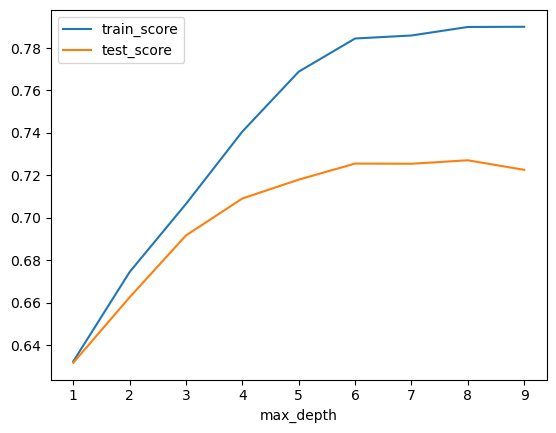

In [74]:
# Plot the results
models_df.plot()

###Results #balanced accuracy score max depth for testing data
* dfx_GradientBoostingClassifier:  Nosample: 2-4 .63-.67  |  Uresampled: 2-3  .67 - 70  |  Oversampled: 2-4  .67 - .71  | smote,teen,tomek,adasyn NA
* train_dum_df: Nosample: 3-4 .67 - .68  |  Uresampled: 3-4, .70 - .71  |  Oversampled: 3-4  .70 - .71

* dfx_RandomForestClassifier: Nosample 5-7 .58 - .64  |  Uresampled: 4-6  .64 - .66 |  Oversampled: 4 - 6 .64 - .66
* train_dum_df: Nosample: 5-6, .61-62  |  Uresampled:5-6, .65-.66   |  Oversampled: 5-6, .65 - .66 


* dfx_ExtraTreesClassifier: Nosample: 4-7, .64-.67|  Uresampled: 5-8, .61 - .63 |  Oversampled: 6-8, .62-.63
* train_dum_df: Nosample: 7-8 .56 - .58 |  Uresampled: 5-6, .60-.62  |  Oversampled: 6-7, .62- .63

* dfx_XGBClassifier: Nosample: 2-3, .67 - .68 |  Uresampled: 2- 3, .69 - .72  |  Oversampled: 2-3, .69-.73
* train_dum_df: Nosample: 6-8, .55 - .58 |  Uresampled: 2-3, .69- .71   |  Oversampled: 2-3, .70-.71

* dfx_LGBMClassifier: Nosample: 2-4 .63 - .675 |  Uresampled: 3, .70  |  Oversampled: 3-4, .70 - .71
* train_dum_df: Nosample: 3-4, .70-.72 |  Uresampled: 3-4, .70- .72   |  Oversampled: 3-4, .70 - .72
  
* df_best_x GradientBoostingClassifier: Resampled: (test_size = .2) 2-4 .67 - .71
* df_best_x GradientBoostingClassifier: Resampled: (test_size = .3) 3 .69
* df_best_x GradientBoostingClassifier: Resampled: default 3 .70


In [316]:
def store_results(model_name, random_search, X_train_resampled, y_train_resampled, X_test, y_test, y_pred, training_df_name, existing_results=None):
    # Initialize a list to store results of different models
    if existing_results is None:
        model_results = []
    else:
        model_results = existing_results
    
    # Create a dictionary for the current model's results
    results_dict = {
        'Model': model_name,
        'Training DF': training_df_name,
        'Best Parameters': random_search.best_params_,
        'Best Cross-Validation Score': random_search.best_score_,
        'Balanced Accuracy Score': balanced_accuracy_score(y_test, y_pred),
        'Training Score': random_search.score(X_train_resampled, y_train_resampled),
        'Testing Score': random_search.score(X_test, y_test),
        'Classification Report': classification_report(y_test, y_pred, output_dict=True) 
    }

    # Append the current results to the list
    model_results.append(results_dict)
    
    # Return the updated list
    return model_results

def display_results(model_results):
    # Print out results for all models in the list
    for idx, model_result in enumerate(model_results, 1):
        print(f"Model {idx}:")
        for key, value in model_result.items():
            if key == 'Classification Report':
                # Convert classification report to pandas DataFrame for tabular display
                report_df = pd.DataFrame(value).transpose()
                print(f"{key}:\n", report_df)
            elif key == 'Best Parameters':
                print(f"{key}:")
                for param, param_value in value.items():
                    print(f"    {param}: {param_value}")
            else:
                print(f"{key}: {value}")
        print("\n" + "="*40 + "\n")  # Separator between models

# Usage example:
# Call `store_results` when you want to add a new model's results
# model_results = store_results('LGBMClassifier', random_search_lgbm, X_train_resampled, y_train_resampled, X_test, y_test, y_pred_lgbm)

# Call `display_results` when you want to display the existing results without adding a new model
# display_results(model_results)


In [429]:


# Define parameter ranges
colsample_bytree_list = np.arange(0.2, 0.4, 0.1)
reg_lambda = [0.1, 0.5, 1.0, 3.0, 5.0, 7.0, 10.0]
max_depth_list = np.arange(2, 4, 1, dtype=int)
max_bin_list = np.arange(15, 100, 15)
n_estimators_list = np.arange(200, 500, 50)
learning_rate_list = np.arange(0.08, 0.16, 0.02)
min_child_weight_list = np.arange(6, 10, 1, dtype=int)
num_leaves_list = [20, 31, 50, 80, 120]

# Create the parameter grid
lgbm_clf_param_grid = {
    'learning_rate': learning_rate_list,
    'max_depth': max_depth_list,
    'min_child_weight': min_child_weight_list,
    'colsample_bytree': colsample_bytree_list,
    'subsample': np.arange(0.8, .9, 0.05),  
    'reg_lambda': reg_lambda,  
    'num_leaves': num_leaves_list,
    'max_bin': max_bin_list,
    'n_estimators': n_estimators_list,  
    'boosting_type': ['gbdt', 'dart',],  
    'class_weight': [None, 'balanced'],  
    'metric': ['binary_logloss', 'auc']  
}



In [ ]:
""" feature selection code to help select the best features for your model"""

# # Step 3: Initialize RFECV
# rfecv = RFECV(
#     estimator=estimator, 
#     step=1, 
#     cv=cv, 
#     scoring='balanced_accuracy', 
#     n_jobs=-1
# )

# # Step 4: Fit RFECV to your training data
# rfecv.fit(X_train_resampled, y_train_resampled)

# # Step 5: Transform the data using the selected features
# X_train_selected = rfecv.transform(X_train_resampled)
# X_test_selected = rfecv.transform(X_test)

In [430]:

# Create the model
lgbm_clf = LGBMClassifier(random_state=13)

# # Feature selection with RandomForest
# selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=13))
# X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
# X_test_selected = selector.transform(X_test)

# set up Stratified K-Fold Cross-Validation for RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
#perform Random search
random_search_lgbm = RandomizedSearchCV(estimator=lgbm_clf, param_distributions=lgbm_clf_param_grid, 
                                      n_iter=100, cv=None, n_jobs=-1, verbose=3, random_state=13, scoring='balanced_accuracy')
random_search_lgbm.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params_lgbm = random_search_lgbm.best_params_
y_pred_lgbm = random_search_lgbm.predict(X_test)

training_df_name='full_df'



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11321, number of negative: 11321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 22642, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [431]:
best_params_lgbm

{'subsample': 0.8500000000000001,
 'reg_lambda': 7.0,
 'num_leaves': 80,
 'n_estimators': 450,
 'min_child_weight': 8,
 'metric': 'binary_logloss',
 'max_depth': 3,
 'max_bin': 75,
 'learning_rate': 0.1,
 'colsample_bytree': 0.30000000000000004,
 'class_weight': None,
 'boosting_type': 'gbdt'}

In [432]:
best_lgbm = random_search_lgbm.best_estimator_
# Get the feature importance array
importances = best_lgbm.feature_importances_
# List the top 10 most important features
feature_importances = pd.Series(importances, index=X_train_resampled.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
assigned_to                  674
subcategory                  337
location                     319
assignment_group             249
day_of_week                  243
category                     190
opened_by                    188
u_symptom                    134
caller_id                    127
month                         77
priority                      67
problem_id                    58
impact                        37
year                          32
knowledge                     23
contact_type_Self service     23
urgency                       14
contact_type_Phone            10
cmdb_ci                        3
contact_type_Email             2
u_priority_confirmation        0
contact_type_IVR               0
notify_Send Email              0
vendor                         0
caused_by                      0
dtype: int32


In [390]:
# # Get the indices of the selected features
# selected_feature_indices = selector.get_support(indices=True)

# # Use the selected indices to get the corresponding feature names
# selected_feature_names = X_train_resampled.columns[selected_feature_indices]

# best_lgbm = random_search_lgbm.best_estimator_
# # Get the feature importance array
# importances = best_lgbm.feature_importances_
# # List the top 10 most important features
# feature_importances = pd.Series(importances, index=selected_feature_names).sort_values(ascending=False)
# print("\nFeature Importances:")
# print(feature_importances)


Feature Importances:
assigned_to         603
assignment_group    374
opened_by           354
category            279
location            272
subcategory         253
u_symptom           234
caller_id           210
day_of_week         172
month               132
dtype: int32


In [433]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_lgbm)}')
print(classification_report( y_test,y_pred_lgbm))

display(f'Training Score: {random_search_lgbm.score(X_train_resampled, y_train_resampled)}')
display(f'Testing Score: {random_search_lgbm.score(X_test, y_test)}')

'balanced accuracy score: 0.7287811858610862'

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      3774
           1       0.63      0.74      0.68      2456

    accuracy                           0.73      6230
   macro avg       0.72      0.73      0.72      6230
weighted avg       0.74      0.73      0.73      6230



'Training Score: 0.7493595972087271'

'Testing Score: 0.7287811858610862'

In [ ]:
"""This code restarts the dictionary, only run if you want to clear the model_results list of dictionaries"""
model_results = store_results(
    'LGBMClassifier',
    random_search_lgbm,
    X_train_resampled,
    y_train_resampled,
    X_test,
    y_test,
    y_pred_lgbm,
    training_df_name)


In [368]:
#Adds model dictionary to the model_results list
model_results = store_results(
    'LGBMClassifier',
    random_search_lgbm,
    X_train_resampled,
    y_train_resampled,
    X_test,
    y_test,
    y_pred_lgbm,
    training_df_name,
    existing_results=model_results  #pass in the results from the previous model
    )


In [380]:
display_results(model_results)

Model 1:
Model: LGBMClassifier
Training DF: df_best_x
Best Parameters:
    subsample: 0.8500000000000001
    reg_lambda: 7.0
    num_leaves: 80
    n_estimators: 450
    min_child_weight: 8
    metric: binary_logloss
    max_depth: 3
    max_bin: 75
    learning_rate: 0.1
    colsample_bytree: 0.30000000000000004
    class_weight: None
    boosting_type: gbdt
Best Cross-Validation Score: 0.7216684412514919
Balanced Accuracy Score: 0.7124917358439106
Training Score: 0.7425139121985691
Testing Score: 0.7124917358439106
Classification Report:
               precision    recall  f1-score      support
0              0.798961  0.692899  0.742160  3774.000000
1              0.608049  0.732085  0.664327  2456.000000
accuracy       0.708347  0.708347  0.708347     0.708347
macro avg      0.703505  0.712492  0.703243  6230.000000
weighted avg   0.723699  0.708347  0.711476  6230.000000


Model 2:
Model: XGBClassifier
Training DF: df_best_x
Best Parameters:
    subsample: 0.8500000000000001
    s

In [337]:
# Define parameter ranges
colsample_bytree_list = np.arange(0.2, 0.4, 0.1)
reg_lambda = [0.1, 0.5, 1.0, 3.0, 5.0, 7.0, 10.0]
max_depth_list = np.arange(2, 4, 1, dtype=int)
n_estimators_list = np.arange(100,250 , 50)
learning_rate_list = np.arange(0.08, 0.2, 0.02)
min_child_weight_list = np.arange(6, 10, 1, dtype=int)


# Create the parameter grid for XGBClassifier
xgb_param_grid = {
    'learning_rate': learning_rate_list,
    'max_depth': max_depth_list,
    'min_child_weight': min_child_weight_list,
    'colsample_bytree': colsample_bytree_list,
    'subsample': np.arange(0.8, .9, 0.05),  
    'reg_lambda': reg_lambda,  
    'n_estimators': n_estimators_list,  
    'gamma': [0, 0.1, 0.5, 1.0],  # XGBoost-specific
    'scale_pos_weight': [1, 2, 3]  # Can be used for imbalance, similar to class_weight
}


In [ ]:
# Feature selection with RandomForest
# selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=13))
# X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
# X_test_selected = selector.transform(X_test)

In [339]:

# Create the model
xgb_clf = XGBClassifier(random_state=13)

# set up Stratified K-Fold Cross-Validation for RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# Perform feature selection using RFECV
rfecv = RFECV(
    estimator=xgb_clf, 
    step=1, 
    cv=cv, 
    scoring='balanced_accuracy', 
    n_jobs=-1
)

rfecv.fit(X_train_resampled, y_train_resampled)

# Transform the data using the selected features
X_train_selected = rfecv.transform(X_train_resampled)
X_test_selected = rfecv.transform(X_test)

#perform Random search
random_search_xgb = RandomizedSearchCV(
    estimator= xgb_clf,
    param_distributions= xgb_param_grid,
    n_iter= 100,
    cv= cv,
    n_jobs= -1,
    verbose= 3,
    random_state= 13,
    scoring= 'balanced_accuracy'
)

random_search_xgb.fit(X_train_selected, y_train_resampled)

# Get the best parameters
best_params = random_search_xgb.best_params_
y_pred_xgb = random_search_xgb.predict(X_test_selected)

training_df_name='full_df'



Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [347]:
best_params

{'subsample': 0.8500000000000001,
 'scale_pos_weight': 1,
 'reg_lambda': 5.0,
 'n_estimators': 200,
 'min_child_weight': 9,
 'max_depth': 3,
 'learning_rate': 0.18000000000000002,
 'gamma': 0.1,
 'colsample_bytree': 0.2}

In [346]:
# Get the indices of the selected features
selected_feature_indices = rfecv.get_support(indices=True)

# Use the selected indices to get the corresponding feature names
selected_feature_names = X_train_resampled.columns[selected_feature_indices]

best_xgb = random_search_xgb.best_estimator_
# Get the feature importance array
importances = best_xgb.feature_importances_
# List the top 10 most important features
feature_importances = pd.Series(importances, index=selected_feature_names).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
knowledge             0.154010
month                 0.153425
assigned_to           0.119089
assignment_group      0.114825
day_of_week           0.074701
opened_by             0.070849
subcategory           0.062380
category              0.058439
location              0.039817
u_symptom             0.033844
caller_id             0.030689
impact                0.022095
contact_type_Phone    0.020126
priority              0.019610
urgency               0.015873
year                  0.010228
dtype: float32


In [341]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_xgb)}')
print(classification_report( y_test,y_pred_xgb))

display(f'Training Score: {random_search_xgb.score(X_train_selected, y_train_resampled)}')
display(f'Testing Score: {random_search_xgb.score(X_test_selected, y_test)}')

'balanced accuracy score: 0.7096866698083406'

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      3774
           1       0.61      0.72      0.66      2456

    accuracy                           0.71      6230
   macro avg       0.70      0.71      0.70      6230
weighted avg       0.72      0.71      0.71      6230



'Training Score: 0.7381856726437594'

'Testing Score: 0.7096866698083406'

In [322]:
model_results = store_results(
    'XGBClassifier', 
    random_search_xgb,
    X_train_resampled, 
    y_train_resampled, 
    X_test, 
    y_test, 
    y_pred_xgb,  #predictions from XGBoost model
    training_df_name,
    existing_results=model_results  #pass in the results from the previous model
)
display_results(model_results)

Model 1:
Model: LGBMClassifier
Training DF: df_best_x
Best Parameters:
    subsample: 0.8500000000000001
    reg_lambda: 7.0
    num_leaves: 80
    n_estimators: 450
    min_child_weight: 8
    metric: binary_logloss
    max_depth: 3
    max_bin: 75
    learning_rate: 0.1
    colsample_bytree: 0.30000000000000004
    class_weight: None
    boosting_type: gbdt
Best Cross-Validation Score: 0.7216684412514919
Balanced Accuracy Score: 0.7124917358439106
Training Score: 0.7425139121985691
Testing Score: 0.7124917358439106
Classification Report:
               precision    recall  f1-score      support
0              0.798961  0.692899  0.742160  3774.000000
1              0.608049  0.732085  0.664327  2456.000000
accuracy       0.708347  0.708347  0.708347     0.708347
macro avg      0.703505  0.712492  0.703243  6230.000000
weighted avg   0.723699  0.708347  0.711476  6230.000000


Model 2:
Model: XGBClassifier
Training DF: df_best_x
Best Parameters:
    subsample: 0.8500000000000001
    s

In [312]:

# Define parameter ranges
max_depth_list = np.arange(2, 3, 1, dtype=int)
n_estimators_list = np.arange(100, 400 , 50)
learning_rate_list = np.arange(0.05, 0.1, 0.01)


gb_param_grid = {
    'learning_rate': learning_rate_list,
    'max_depth': max_depth_list,
    'min_samples_split': np.arange(4, 10, 2),  # Similar to min_child_weight
    'min_samples_leaf': np.arange(2, 6, 1),  # To replace num_leaves
    'subsample': np.arange(0.7, 0.9, 0.05),  
    'n_estimators': n_estimators_list,  
    'max_features': [ 'sqrt', 'log2', None],  # Replaces colsample_bytree
}

In [ ]:
# Feature selection with RandomForest
# selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=13))
# X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
# X_test_selected = selector.transform(X_test)

In [355]:



# Create the model
gb_clf = GradientBoostingClassifier(random_state=13)



# Feature selection with RandomForest
selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=13))
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = selector.transform(X_test)


#set up Stratified K-Fold Cross-Validation for RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

#perform Random search
random_search_gb = RandomizedSearchCV(
    estimator=gb_clf,
    param_distributions=gb_param_grid,
    n_iter=100,
    cv=cv,
    n_jobs=-1,
    verbose=3,
    random_state=13,
    scoring='balanced_accuracy'
    )

random_search_gb.fit(X_train_selected, y_train_resampled)

# Get the best parameters
best_params_gb = random_search_gb.best_params_

y_pred_gb = random_search_gb.predict(X_test_selected)

training_df_name='full_df-rfecv'



Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [352]:
best_params_gb

{'subsample': 0.8500000000000001,
 'n_estimators': 350,
 'min_samples_split': 8,
 'min_samples_leaf': 5,
 'max_features': None,
 'max_depth': 2,
 'learning_rate': 0.09000000000000001}

In [357]:
# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Use the selected indices to get the corresponding feature names
selected_feature_names = X_train_resampled.columns[selected_feature_indices]

best_gb = random_search_gb.best_estimator_
# Get the feature importance array
importances = best_gb.feature_importances_
# List the top 10 most important features
feature_importances = pd.Series(importances, index=selected_feature_names).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
assigned_to         0.242773
assignment_group    0.235120
month               0.214380
opened_by           0.095073
day_of_week         0.057487
location            0.039248
u_symptom           0.033065
category            0.032519
subcategory         0.032048
caller_id           0.018287
dtype: float64


In [353]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_gb)}')
print(classification_report( y_test,y_pred_gb))

display(f'Training Score: {random_search_gb.score(X_train_selected, y_train_resampled)}')
display(f'Testing Score: {random_search_gb.score(X_test_selected, y_test)}')

'balanced accuracy score: 0.7048623877757811'

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      3774
           1       0.60      0.73      0.66      2456

    accuracy                           0.70      6230
   macro avg       0.70      0.70      0.70      6230
weighted avg       0.72      0.70      0.70      6230



'Training Score: 0.7178252804522569'

'Testing Score: 0.7048623877757811'

In [ ]:
model_results = store_results(
    'GradientBoostingClassifier',
    random_search_gb,
    X_train_resampled,
    y_train_resampled,
    X_test,
    y_test,
    y_pred_gb,
    training_df_name,
    existing_results=model_results #pass in the results from the previous model
    )  


In [372]:
display_results(model_results)

Model 1:
Model: LGBMClassifier
Training DF: df_best_x
Best Parameters:
    subsample: 0.8500000000000001
    reg_lambda: 7.0
    num_leaves: 80
    n_estimators: 450
    min_child_weight: 8
    metric: binary_logloss
    max_depth: 3
    max_bin: 75
    learning_rate: 0.1
    colsample_bytree: 0.30000000000000004
    class_weight: None
    boosting_type: gbdt
Best Cross-Validation Score: 0.7216684412514919
Balanced Accuracy Score: 0.7124917358439106
Training Score: 0.7425139121985691
Testing Score: 0.7124917358439106
Classification Report:
               precision    recall  f1-score      support
0              0.798961  0.692899  0.742160  3774.000000
1              0.608049  0.732085  0.664327  2456.000000
accuracy       0.708347  0.708347  0.708347     0.708347
macro avg      0.703505  0.712492  0.703243  6230.000000
weighted avg   0.723699  0.708347  0.711476  6230.000000


Model 2:
Model: XGBClassifier
Training DF: df_best_x
Best Parameters:
    subsample: 0.8500000000000001
    s

In [371]:
# #Delete the 6th dictionary (index 5) from the list
# del model_results[5]

# #Confirm the deletion
# print("5th dictionary (Lgbm 6) removed.")

5th dictionary (Lgbm 6) removed.


In [240]:

# Define parameter ranges
max_depth_list = np.arange(2, 3, 1, dtype=int)
n_estimators_list = np.arange(100, 400 , 50)



# Define parameter ranges for RandomForestClassifier
rf_param_grid = {
    'max_depth': max_depth_list,  # Maximum depth of the tree
    'min_samples_split': np.arange(4, 10, 2),  # Minimum number of samples required to split a node
    'min_samples_leaf': np.arange(2, 6, 1),  # Minimum number of samples required to be at a leaf node
    'n_estimators': n_estimators_list,  # Number of trees in the forest
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
    'bootstrap': [True, False],  # Whether to bootstrap samples when building trees
}


In [241]:



# Create the model
rf = RandomForestClassifier(random_state=13)

# Feature selection with RandomForest
# selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=13))
# X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
# X_test_selected = selector.transform(X_test)

# set up Stratified K-Fold Cross-Validation for RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
#perform Random search
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, 
                                      n_iter=100, cv=cv, n_jobs=-1, verbose=3, random_state=13, scoring='balanced_accuracy')
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params_rf = random_search_rf.best_params_
y_pred_rf = random_search_rf.predict(X_test)

training_df_name='full_df'



Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [242]:
best_params_rf

{'n_estimators': 300,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 2,
 'bootstrap': True}

In [243]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_rf)}')
print(classification_report( y_test,y_pred_rf))

display(f'Training Score: {random_search_rf.score(X_train_resampled, y_train_resampled)}')
display(f'Testing Score: {random_search_rf.score(X_test, y_test)}')

'balanced accuracy score: 0.6119956059719425'

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      3774
           1       0.54      0.51      0.52      2456

    accuracy                           0.63      6230
   macro avg       0.61      0.61      0.61      6230
weighted avg       0.63      0.63      0.63      6230



'Training Score: 0.6129317198127374'

'Testing Score: 0.6119956059719425'

RandomForestClassifier repeatedly had the lowest all around scores for every training set, and thus we will not be storing any of the model results.

In [408]:
display_results(model_results)

Model 1:
Model: LGBMClassifier
Training DF: df_best_x
Best Parameters:
    subsample: 0.8500000000000001
    reg_lambda: 7.0
    num_leaves: 80
    n_estimators: 450
    min_child_weight: 8
    metric: binary_logloss
    max_depth: 3
    max_bin: 75
    learning_rate: 0.1
    colsample_bytree: 0.30000000000000004
    class_weight: None
    boosting_type: gbdt
Best Cross-Validation Score: 0.7216684412514919
Balanced Accuracy Score: 0.7124917358439106
Training Score: 0.7425139121985691
Testing Score: 0.7124917358439106
Classification Report:
               precision    recall  f1-score      support
0              0.798961  0.692899  0.742160  3774.000000
1              0.608049  0.732085  0.664327  2456.000000
accuracy       0.708347  0.708347  0.708347     0.708347
macro avg      0.703505  0.712492  0.703243  6230.000000
weighted avg   0.723699  0.708347  0.711476  6230.000000


Model 2:
Model: XGBClassifier
Training DF: df_best_x
Best Parameters:
    subsample: 0.8500000000000001
    s

# Conclusion
Model 6 is our best model with a balanced accuracy score of 73%, and an acceptable 2% overfitting error between the training and testing scores. Model 6 uses the LGBMClassifier with hyperparmeter tuning,  Randomsearchcv to find the best parameters for the model. This information is all store in the model results list as a dictionary.  it uses the full_df for its training and testing data which includes all the features that would available from the first instance the ticket is created.
